## Projet Bayésien
Guillaume et Yanis **<3**

## Introduction du problème 

Le problème développé dans ce projet est d'implémenter un échantillonneur selon le modèle statistique donné par le pack de données choisi. 
Nous travaillerons sur le dataset **Eyes**. Il s'agit d'un ensemble de mesures de longueurs d'ondes pour lesquelles les singes qui ont été testés ont une sensibilité maximale. Nos données sont donc en nanomètres.


Ce projet s'articulera en trois mouvements :
- Importation du dataset
- Etude approfondie des modèles statistiques à implémenter
- Implémentation d'un sampler de Gibbs pour la génération d'un échantillon suivant les loi données par le dataset **Eyes**. On implémentera un échantillonneur pour chacun des deux modèles présentés dans le dataset, afin de pouvoir se rendre compte de l'effet d'attraction de classe.

Importation des **Data** :

In [12]:
# Simulation et analyse des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [4]:
# Conversion du fichier eyes.data.R en Python
N = 48
y = np.array([
    529, 530, 532, 533.1, 533.4, 533.6, 533.7, 534.1, 534.8, 535.3,
    535.4, 535.9, 536.1, 536.3, 536.4, 536.6, 537, 537.4, 537.5,
    538.3, 538.5, 538.6, 539.4, 539.6, 540.4, 540.8, 542, 542.8,
    543, 543.5, 543.8, 543.9, 545.3, 546.2, 548.8, 548.7, 548.9,
    549, 549.4, 549.9, 550.6, 551.2, 551.4, 551.5, 551.6, 552.8,
    552.9, 553.2
])
alpha = np.array([1.0, 1.0])

# Conversion du fichier eyes.init.R en Python
lambda_1 = 535
theta = 5
sigmasq = 10
p1 = 0.5


In [17]:
# Création d'un DataFrame pour analyser les données
df1 = pd.DataFrame({'y': y})
print(df1.describe())

                y
count   48.000000
mean   541.533333
std      7.022406
min    529.000000
25%    536.050000
50%    540.000000
75%    548.825000
max    553.200000


Dans l'analyse de l'équipe de Bowmaker et Al., les chercheurs ont retiré 500nm à toutes les valeurs des observations. Nous allons aussi procéder à ce prétraitement.

In [18]:
df = pd.DataFrame({'y': y-500})
print(df.describe()) 

               y
count  48.000000
mean   41.533333
std     7.022406
min    29.000000
25%    36.050000
50%    40.000000
75%    48.825000
max    53.200000


## Etude du modèle statistique non corrigé

DAG + lois conditionnelles (normalement c'est juste une gaussienne classique mais il faut prendre en plus le fait qu'on puisse changer de variable pour le lambda)

Voir rapport

In [ ]:
n_iter = 5

## Implémentation de l'échantillonneur de Gibbs pour le modèle initial

In [ ]:
import numpy as np
from scipy.stats import norm, gamma, dirichlet, truncnorm

# Données et hyperparamètres
N = len(y) 
alpha = np.array([1, 1]) # non informatif

# Hyperparamètres pour les priors de lambda_1 et theta
precision_prior = 1.0E-6 

# Initialisations, on essaye d'être le moins informatif possible
lambda1 = np.mean(y)
theta = 1.0
tau = 1.0
P = np.array([0.5, 0.5]) 
T = np.random.choice([1, 2], size=N, p=P) 

n_iter = 5000
# On crée les variables de stockage
samples_lambda1 = np.zeros(n_iter)
samples_theta = np.zeros(n_iter)
samples_tau = np.zeros(n_iter)
samples_P = np.zeros((n_iter, 2))

for it in range(n_iter):
    # Update des T[i]
    for i in range(N):
        # Calculer la densité pour chaque composante
        p1 = P[0] * norm.pdf(y[i], loc=lambda1, scale=1/np.sqrt(tau))
        p2 = P[1] * norm.pdf(y[i], loc=lambda1 + theta, scale=1/np.sqrt(tau))
        prob1 = p1 / (p1 + p2)
        # Tirer T_i
        T[i] = 1 if np.random.rand() < prob1 else 2

    # Comptages
    n1 = np.sum(T == 1)
    n2 = np.sum(T == 2)
    
    # Update de P
    # Dirichlet avec paramètres (alpha1+n1, alpha2+n2)
    P = dirichlet.rvs(alpha + np.array([n1, n2]))[0]
    
    # Update de tau
    # Calcul de la somme des carrés des résidus
    resid = np.array([y[i] - (lambda1 if T[i]==1 else lambda1+theta) for i in range(N)])
    S = np.sum(resid**2)
    tau = gamma.rvs(0.001 + N/2, scale=1.0/(0.001 + S/2))
    
    # Update de lambda_1
    # Sums selon les groupes
    S1 = np.sum(y[T == 1])
    S2 = np.sum(y[T == 2] - theta)
    var_lambda1 = 1.0 / (tau * (n1 + n2) + precision_prior)
    mu_lambda1  = var_lambda1 * tau * (S1 + S2)
    lambda1 = norm.rvs(loc=mu_lambda1, scale=np.sqrt(var_lambda1))
    
    # Update de theta
    # Pour theta, seules les observations du groupe 2 interviennent
    if n2 > 0:
        S2_prime = np.sum(y[T == 2] - lambda1)
        var_theta = 1.0 / (tau * n2 + precision_prior)
        mu_theta  = var_theta * tau * S2_prime
        # Échantillonnage de theta à partir d'une normale tronquée à (0, inf)
        a, b = (0 - mu_theta) / np.sqrt(var_theta), np.inf
        theta = truncnorm.rvs(a, b, loc=mu_theta, scale=np.sqrt(var_theta))
    else:
        # Si aucun y n'est assigné à 2, on choisit de garder la valeur précédente
        theta = theta

    # Stockage des échantillons
    samples_lambda1[it] = lambda1
    samples_theta[it] = theta
    samples_tau[it] = tau
    samples_P[it, :] = P


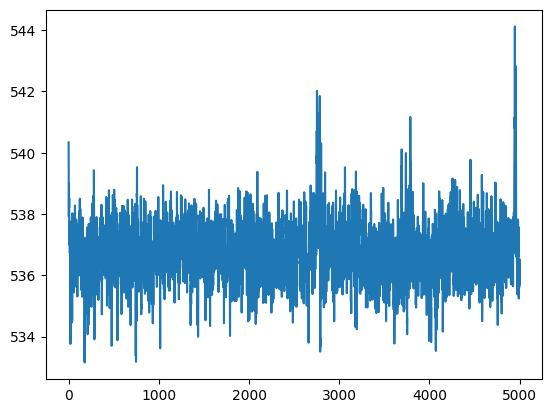

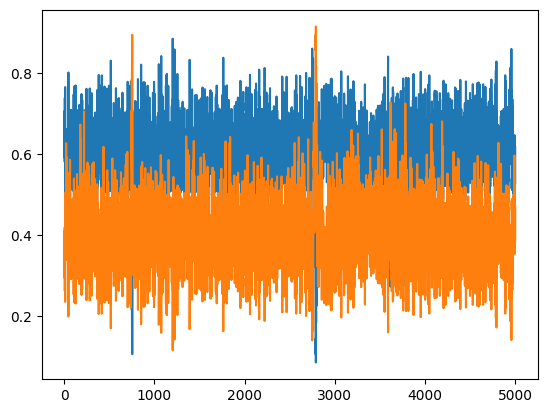

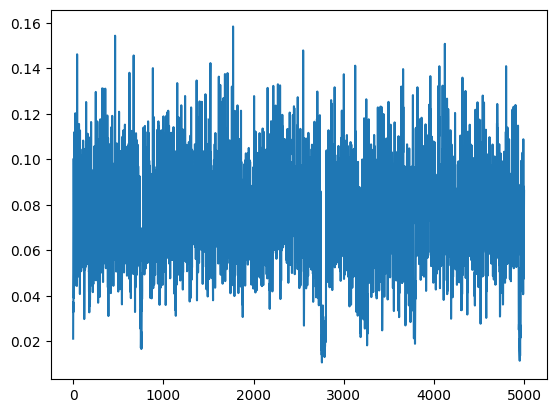

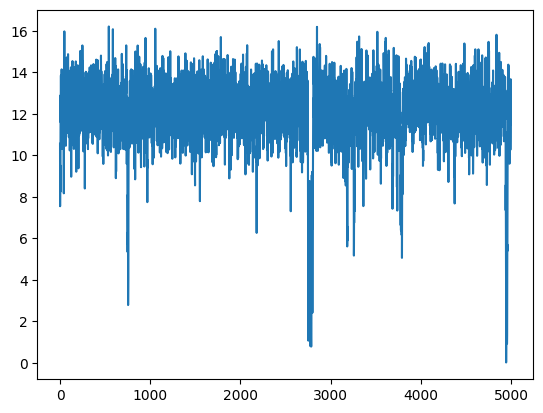

In [19]:
plt.plot(samples_lambda1)
plt.figure()
plt.plot(samples_P)
plt.figure()
plt.plot(samples_tau)
plt.figure()
plt.plot(samples_theta)

## Etude du modèle statistique corrigé

skibidi la suite

## Implémentation de la correction

Nouvelle version voir le fichier Bayes version locale